The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps --force-reinstall
!pip install numpy>=1.20

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-1_ijbol5
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-1_ijbol5
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110800 sha256=4e170cb4e4e62f3cf62862df3900e6332b96cc9cce5261b1e8265a898af77237
  Stored in directory: /tmp/pip-ephem-wheel-cache-j13q59i6/wheels/53/15/45/14b38ed62d9bc53ab3de439d4c2a79f70a00112eeeadcf6c34
Successfully built d2l


# 残差网络（ResNet）
:label:`sec_resnet`

随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力，
为了取得质的突破，我们需要一些数学基础知识。

## 函数类

首先，假设有一类特定的神经网络架构$\mathcal{F}$，它包括学习速率和其他超参数设置。
对于所有$f \in \mathcal{F}$，存在一些参数集（例如权重和偏置），这些参数可以通过在合适的数据集上进行训练而获得。
现在假设$f^*$是我们真正想要找到的函数，如果是$f^* \in \mathcal{F}$，那我们可以轻而易举的训练得到它，但通常我们不会那么幸运。
相反，我们将尝试找到一个函数$f^*_\mathcal{F}$，这是我们在$\mathcal{F}$中的最佳选择。
例如，给定一个具有$\mathbf{X}$特性和$\mathbf{y}$标签的数据集，我们可以尝试通过解决以下优化问题来找到它：

$$f^*_\mathcal{F} := \mathop{\mathrm{argmin}}_f L(\mathbf{X}, \mathbf{y}, f) \text{ subject to } f \in \mathcal{F}.$$

那么，怎样得到更近似真正$f^*$的函数呢？
唯一合理的可能性是，我们需要设计一个更强大的架构$\mathcal{F}'$。
换句话说，我们预计$f^*_{\mathcal{F}'}$比$f^*_{\mathcal{F}}$“更近似”。
然而，如果$\mathcal{F} \not\subseteq \mathcal{F}'$，则无法保证新的体系“更近似”。
事实上，$f^*_{\mathcal{F}'}$可能更糟：
如 :numref:`fig_functionclasses`所示，对于非嵌套函数（non-nested function）类，较复杂的函数类并不总是向“真”函数$f^*$靠拢（复杂度由$\mathcal{F}_1$向$\mathcal{F}_6$递增）。
在 :numref:`fig_functionclasses`的左边，虽然$\mathcal{F}_3$比$\mathcal{F}_1$更接近$f^*$，但$\mathcal{F}_6$却离的更远了。
相反对于 :numref:`fig_functionclasses`右侧的嵌套函数（nested function）类$\mathcal{F}_1 \subseteq \ldots \subseteq \mathcal{F}_6$，我们可以避免上述问题。

![对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（ $f^*$ ）。这种现象在嵌套函数类中不会发生。](http://d2l.ai/_images/functionclasses.svg)
:label:`fig_functionclasses`

因此，只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能。
对于深度神经网络，如果我们能将新添加的层训练成*恒等映射*（identity function）$f(\mathbf{x}) = \mathbf{x}$，新模型和原模型将同样有效。
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

针对这一问题，何恺明等人提出了*残差网络*（ResNet） :cite:`He.Zhang.Ren.ea.2016`。
它在2015年的ImageNet图像识别挑战赛夺魁，并深刻影响了后来的深度神经网络的设计。
残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。
于是，*残差块*（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。
凭借它，ResNet赢得了2015年ImageNet大规模视觉识别挑战赛。

## (**残差块**)

让我们聚焦于神经网络局部：如图 :numref:`fig_residual_block`所示，假设我们的原始输入为$x$，而希望学出的理想映射为$f(\mathbf{x})$（作为 :numref:`fig_residual_block`上方激活函数的输入）。
 :numref:`fig_residual_block`左图虚线框中的部分需要直接拟合出该映射$f(\mathbf{x})$，而右图虚线框中的部分则需要拟合出残差映射$f(\mathbf{x}) - \mathbf{x}$。
残差映射在现实中往往更容易优化。
以本节开头提到的恒等映射作为我们希望学出的理想映射$f(\mathbf{x})$，我们只需将 :numref:`fig_residual_block`中右图虚线框内上方的加权运算（如仿射）的权重和偏置参数设成0，那么$f(\mathbf{x})$即为恒等映射。
实际中，当理想映射$f(\mathbf{x})$极接近于恒等映射时，残差映射也易于捕捉恒等映射的细微波动。
 :numref:`fig_residual_block`右图是ResNet的基础架构--*残差块*（residual block）。
在残差块中，输入可通过跨层数据线路更快地向前传播。

![一个正常块（左图）和一个残差块（右图）。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/residual-block.svg?raw=1)
:label:`fig_residual_block`

ResNet沿用了VGG完整的$3\times 3$卷积层设计。
残差块里首先有2个有相同输出通道数的$3\times 3$卷积层。
每个卷积层后接一个批量规范化层和ReLU激活函数。
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。
这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。
如果想改变通道数，就需要引入一个额外的$1\times 1$卷积层来将输入变换成需要的形状后再做相加运算。
残差块的实现如下：


In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) #卷积层 batchnormalization relu
        Y = self.bn2(self.conv2(Y))#卷积层 + batch normalization
        if self.conv3:
            X = self.conv3(X)
        Y += X #
        return F.relu(Y)

如 :numref:`fig_resnet_block`所示，此代码生成两种类型的网络：
一种是当`use_1x1conv=False`时，应用ReLU非线性函数之前，将输入添加到输出。
另一种是当`use_1x1conv=True`时，添加通过$1 \times 1$卷积调整通道和分辨率。

![包含以及不包含 $1 \times 1$ 卷积层的残差块。](https://github.com/d2l-ai/d2l-zh-pytorch-colab/blob/master/img/resnet-block.svg?raw=1)
:label:`fig_resnet_block`

下面我们来查看[**输入和输出形状一致**]的情况。


In [3]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

我们也可以在[**增加输出通道数的同时，减半输出的高和宽**]。


In [4]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## [**ResNet模型**]

ResNet的前两层跟之前介绍的GoogLeNet中的一样：
在输出通道数为64、步幅为2的$7 \times 7$卷积层后，接步幅为2的$3 \times 3$的最大汇聚层。
不同之处在于ResNet每个卷积层后增加了批量规范化层。


In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。
第一个模块的通道数同输入通道数一致。
由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。
之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。


In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2)) #开始尺寸减半
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。


In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) #true的话 第一个block是不带use_1X1conv的
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。


In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

每个模块有4个卷积层（不包括恒等映射的$1\times 1$卷积层）。
加上第一个$7\times 7$卷积层和最后一个全连接层，共有18层。
因此，这种模型通常被称为ResNet-18。
通过配置不同的通道数和模块里的残差块数可以得到不同的ResNet模型，例如更深的含152层的ResNet-152。
虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用。
 :numref:`fig_resnet18`描述了完整的ResNet-18。

![ResNet-18 架构](http://d2l.ai/_images/resnet18.svg)
:label:`fig_resnet18`

在训练ResNet之前，让我们[**观察一下ResNet中不同模块的输入形状是如何变化的**]。
在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。


In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net: #直接一层层调用？
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


## [**训练模型**]

同之前一样，我们在Fashion-MNIST数据集上训练ResNet。


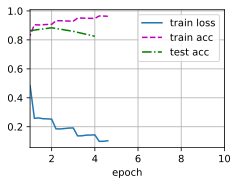

In [ ]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

## 小结

* 学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。
* 残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。
* 利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。
* 残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

## 练习

1.  :numref:`fig_inception`中的Inception块与残差块之间的主要区别是什么？在删除了Inception块中的一些路径之后，它们是如何相互关联的？
1. 参考ResNet论文 :cite:`He.Zhang.Ren.ea.2016`中的表1，以实现不同的变体。
1. 对于更深层次的网络，ResNet引入了“bottleneck”架构来降低模型复杂性。请试着去实现它。
1. 在ResNet的后续版本中，作者将“卷积层、批量规范化层和激活层”架构更改为“批量规范化层、激活层和卷积层”架构。请尝试做这个改进。详见 :cite:`He.Zhang.Ren.ea.2016*1`中的图1。
1. 为什么即使函数类是嵌套的，我们仍然要限制增加函数的复杂性呢？


# ======================
# 一、Inception块与残差块的主要区别
# ======================

"""
1. 结构设计差异
------------------------------------------
• Inception块:
  - 并行多路径结构
  - 每条路径执行不同操作(1×1卷积/3×3卷积/5×5卷积/池化等)
  - 输出在通道维度拼接(concatenate)
  
• 残差块:
  - 跳跃连接结构(skip connection)
  - 输入直接与卷积层输出相加(add)
  - 典型结构: 两个卷积层(含BN和ReLU)

2. 功能目标差异
------------------------------------------
• Inception块:
  - 多尺度特征融合
  - 计算效率优化(通过1×1卷积降维)
  
• 残差块:
  - 解决梯度消失/爆炸问题
  - 缓解网络退化问题
  - 支持极深层网络训练

3. 特征融合方式对比
------------------------------------------
| 特性         | Inception块             | 残差块               |
|--------------|-------------------------|---------------------|
| 融合操作     | 通道拼接                | 逐元素相加          |
| 输出变化     | 增加通道数              | 保持通道数不变      |
| 特征处理     | 保留各路径原始特征      | 强调特征复用        |

4. 典型应用对比
------------------------------------------
• Inception块: GoogleNet (Inception v1-v4)
• 残差块: ResNet及其变体
"""

# ======================
# 二、删除路径后的关联性
# ======================

"""
1. 删除路径后的Inception块特性
------------------------------------------
• 仍保持并行路径基本结构
• 特征多样性降低
• 输出仍是多路径特征拼接
  示例: 仅保留1×1和3×3路径时:
        ┌─1×1卷积─┐
    输入─┤          ├─拼接→输出
        └─3×3卷积─┘

2. 与残差块的本质区别
------------------------------------------
• 无法退化为残差块的核心原因:
  - 缺少跳跃连接设计
  - 特征融合方式不同(拼接 vs 相加)
  
• 结构对比示意图:
  残差块结构:
    输入─┬─卷积层─┐
        │        ├─相加→输出
        └───────┘

3. 可能的融合设计
------------------------------------------
• 需额外设计才能实现转化:
  - 引入跳跃连接
  - 将拼接改为相加操作
  示例: Inception-ResNet中的残差连接设计
"""

[Discussions](https://discuss.d2l.ai/t/1877)


在神经网络中，它表示某一层（或模块）的输入特征直接无损传递到输出。
操作等价：
对任意输入数据，不做任何变换（如旋转/缩放/平移），直接返回原值。
### 🧠 神经网络中恒等映射的意义

| **场景**               | **传统网络层**                          | **恒等映射的作用**                     |
|------------------------|----------------------------------------|----------------------------------------|
| **不需要特征变换时**   | 需精确学习 $W=0, b=0$ 实现 $y=x$       | **天然满足** $y = \text{skip}(x) = x$ |
| **深层网络冗余层**     | 可能破坏已有特征                       | 允许多余层"无害化"跳过变换             |
| **梯度传播**           | 逐层衰减                               | 通过跳跃连接**无损传播梯度**           |
| **优化难度**           | 需精确调整参数实现恒等映射 ★★★★☆        | 残差项趋零即可实现 ★☆☆☆☆               |
| **特征保留能力**       | 容易丢失原始特征                       | 原始特征通过跳跃连接直接保留           |

In [3]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release --no-deps --force-reinstall
!pip install numpy>=1.20

  Cloning https://github.com/d2l-ai/d2l-zh (to revision release) to /tmp/pip-req-build-vt7s_5ih
  Running command git clone --filter=blob:none --quiet https://github.com/d2l-ai/d2l-zh /tmp/pip-req-build-vt7s_5ih
  Running command git checkout -b release --track origin/release
  Switched to a new branch 'release'
  Branch 'release' set up to track remote branch 'release' from 'origin'.
  Resolved https://github.com/d2l-ai/d2l-zh to commit 843d3d41dca48d8df65f4b324dd171d8bfe9c067
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for d2l: filename=d2l-2.0.0-py3-none-any.whl size=110870 sha256=e704869ccbb4bd380e004aee46edee2aa24291adcce632ff6098f2df5be867f6
  Stored in directory: /tmp/pip-ephem-wheel-cache-v4iqx0y7/wheels/53/15/45/14b38ed62d9bc53ab3de439d4c2a79f70a00112eeeadcf6c34
Successfully built d2l


In [9]:
#ResNet-18、34、50、101、152
#b1已经有两层 卷积层和maxpool层 网络的总层数通常指的是“带权重的层”，包括卷积层和全连接层，而池化层不计入总层数（因为池化层没有可训练参数）。
#b1 层只有一层 resnet18没有b1

import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X))) #卷积层 batchnormalization relu
        Y = self.bn2(self.conv2(Y))#卷积层 + batch normalization
        if self.conv3:
            X = self.conv3(X)
        Y += X #
        return F.relu(Y)

b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2)) #开始尺寸减半
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True)) #true的话 第一个block是不带use_1X1conv的。每个block是包含两个残差块 一个残差块就是两层卷积
b3 = nn.Sequential(*resnet_block(64, 128, 2)) #1 + 4 + 4 + 4 + 1
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
net = nn.Sequential(b1, b2, b3, b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)), #一个channel只保留一个数
                    nn.Flatten(), nn.Linear(512, 10)
                    )
X = torch.rand(size=(1, 1, 224, 224))
for layer in net: #直接一层层调用？
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

'''
BatchNorm层不计入总层数
只有卷积层(Conv)和全连接层(FC)被计数
这是行业通用标准（与VGG、AlexNet等一致）
'''

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


'\nBatchNorm层不计入总层数\n只有卷积层(Conv)和全连接层(FC)被计数\n这是行业通用标准（与VGG、AlexNet等一致）\n'

In [ ]:
#ResNet-34
import torch
import torch.nn as nn
import torch.nn.functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# 初始卷积层（计入1层）
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 构建32层ResNet（卷积层总数=1+3*2+4*2+6*2+3*2=32）
# 阶段1：3个残差块（6层）
b2 = nn.Sequential(*resnet_block(64, 64, 3, first_block=True))
# 阶段2：4个残差块（8层）
b3 = nn.Sequential(*resnet_block(64, 128, 4))
# 阶段3：6个残差块（12层）
b4 = nn.Sequential(*resnet_block(128, 256, 6))
# 阶段4：3个残差块（6层）
b5 = nn.Sequential(*resnet_block(256, 512, 3))

# 完整网络（总层数=32卷积层+1全连接层=33层）
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 1000)  # 假设1000类分类
)

# 验证网络结构
print(net)

# 测试输入输出
X = torch.rand(1, 3, 224, 224)  # 批大小1, 3通道, 224x224
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Bottleneck(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1, reduction=4):
        """
        Args:
            input_channels: 输入通道数
            num_channels: 输出通道数
            use_1x1conv: 是否在shortcut路径使用1x1卷积
            strides: 卷积步幅（用于下采样）
            reduction: 瓶颈压缩比例（默认4倍）
        """
        super().__init__()
        # 计算中间层的通道数（瓶颈层）
        bottleneck_channels = num_channels // reduction #chanenl直接压缩4倍 就多了一个输出维度减少。多一个维度就多一个那个维度的模版

        # 第一层：1x1卷积（降维）
        self.conv1 = nn.Conv2d(input_channels, bottleneck_channels,
                               kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        # 第二层：3x3卷积（主特征提取）
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        # 第三层：1x1卷积（升维）
        self.conv3 = nn.Conv2d(bottleneck_channels, num_channels,
                               kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(num_channels)

        # Shortcut连接 通常情况下 这个不算一层
        if use_1x1conv:
            self.conv_shortcut = nn.Conv2d(input_channels, num_channels,
                                           kernel_size=1, stride=strides)
        else:
            self.conv_shortcut = None

    def forward(self, X):
        # 主路径
        Y = F.relu(self.bn1(self.conv1(X)))   # 降维
        Y = F.relu(self.bn2(self.conv2(Y)))   # 3x3卷积
        Y = self.bn3(self.conv3(Y))           # 升维（不立即激活）

        # Shortcut路径
        if self.conv_shortcut:
            X = self.conv_shortcut(X)

        # 残差连接 + 激活
        Y += X
        return F.relu(Y)

In [13]:
#resnet-50
def resnet_bottleneck_block(input_channels, num_channels, num_blocks, first_block=False):
    blk = []
    for i in range(num_blocks):
        strides = 1
        use_1x1conv = False

        # 第一个块可能需要下采样
        if i == 0:
            if not first_block:
                strides = 2  # 特征图尺寸减半
                use_1x1conv = True
            elif input_channels != num_channels:
                use_1x1conv = True  # 通道数变化时需要1x1卷积
        #bottle net名字起的其实就是封装了个容器。resnet_bottleneck_block
        blk.append(Bottleneck(
            input_channels if i == 0 else num_channels,
            num_channels,
            use_1x1conv=use_1x1conv,
            strides=strides
        ))
    return blk

# 构建ResNet-50
b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3), #第一层
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 各阶段配置：[块数量, 输出通道数]
config = [
    (3, 256),  # stage1: 3个bottleneck, 输出256通道。3*3 = 9
    (4, 512),  # stage2   12
    (6, 1024), # stage3  18
    (3, 2048)  # stage4 9
]
#一共48层 前后两层 一共50层
# 构建网络
stages = nn.Sequential()
input_channels = 64
for i, (num_blocks, num_channels) in enumerate(config):
    first_block = (i == 0)
    stage = resnet_bottleneck_block(
        input_channels, num_channels, num_blocks, first_block
    )
    stages.add_module(f"stage{i+1}", nn.Sequential(*stage))
    input_channels = num_channels

net = nn.Sequential(
    b1,
    stages,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(2048, 1000)  # ImageNet分类
)
#- 例如：输入尺寸为 `(B, C, H, W)`，经过 `nn.AdaptiveAvgPool2d((1,1))` 后，输出尺寸为 `(B, C, 1, 1)`。
print(net)

# 测试输入输出
X = torch.rand(1, 3, 224, 224)  # 批大小1, 3通道, 224x224
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (stage1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      )
      (1): Bottleneck(
        (conv1): Conv2d

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(input_channels)  # 归一化输入通道数
        self.bn2 = nn.BatchNorm2d(num_channels)    # 归一化输出通道数

    def forward(self, X):
        # 新顺序: BN → ReLU → Conv
        Y = self.conv1(F.relu(self.bn1(X)))       # 第一层: BN → ReLU → Conv
        Y = self.conv2(F.relu(self.bn2(Y)))        # 第二层: BN → ReLU → Conv

        # 残差连接处理
        if self.conv3:
            X = self.conv3(X)

        Y += X  # 残差连接
        return Y  # 注意: 不再有最后的ReLU

"所有模型都是错的，但有些是有用的" - George Box。限制复杂性正是为了找到那个"有用"的模型，而非追求完美拟合数据却无泛化能力的模型。

---

